# Prerequisites

In [31]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

# Prepare data

## Import price data

โหลดข้อมูลราคาข้าวเปลือกที่เกษตรกรขายได้ 3 ชนิดข้าว ได้แก่ ข้าวหอมมะลิ (`hml`) ข้าวเจ้าขาว (`wht`) และข้าวเหนียว (`glu`)  
นอกจากนี้ ยังเพิ่มข้อมูล metadata ประกอบด้วยตัวย่อ(abb) ชื่อย่อ (shortname) และ ชื่อเต็ม(fullname)

In [32]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

## Policy data
เพิ่มข้อมูล dummy ปีที่มีนโยบายจำนำข้าวทุกเมล็ดของรัฐบาลยิ่งลักษณ์ ระหว่าง Oct 2011 - Feb 2014

In [33]:
exo = pd.DataFrame(index = wht.index)
exo['pledge_scheme'] = 0
exo.loc['2011-10':'2014-2'] = 1

## Visualization

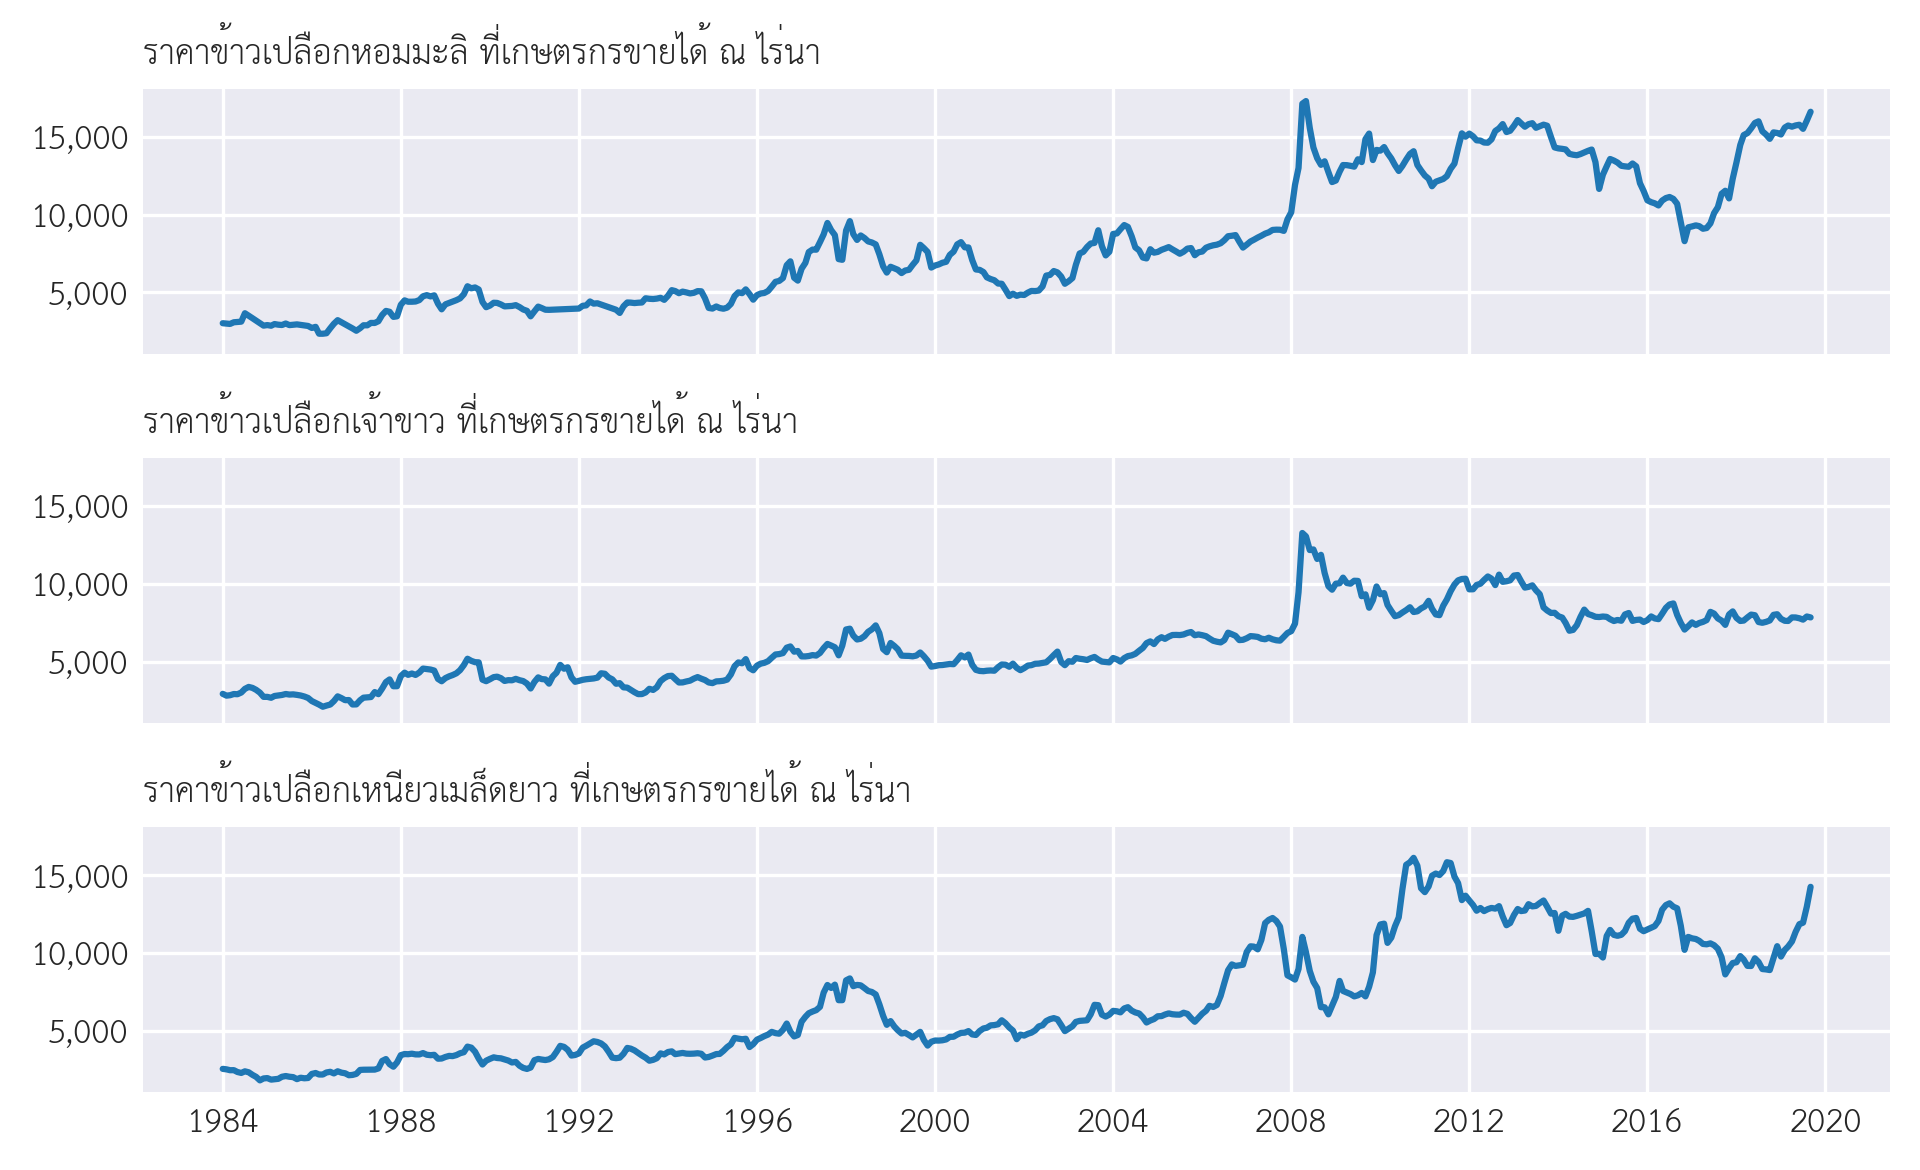

In [34]:
# fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
# # fig.subplots_adjust(hspace=1)
# for i, price in enumerate(prices):
#     ax.plot(price.index, price.actual)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# plt.tight_layout()
# # fig.savefig('../figures/01_price plot.png', dpi=300)

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6.5, 4))
for i, price in enumerate(prices):
    ax[i].plot(price.index, price.y)
    ax[i].set_title(price.meta.fullname, loc='left')
ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
# fig.savefig('../figures/01_prices_plot.png', dpi=300)

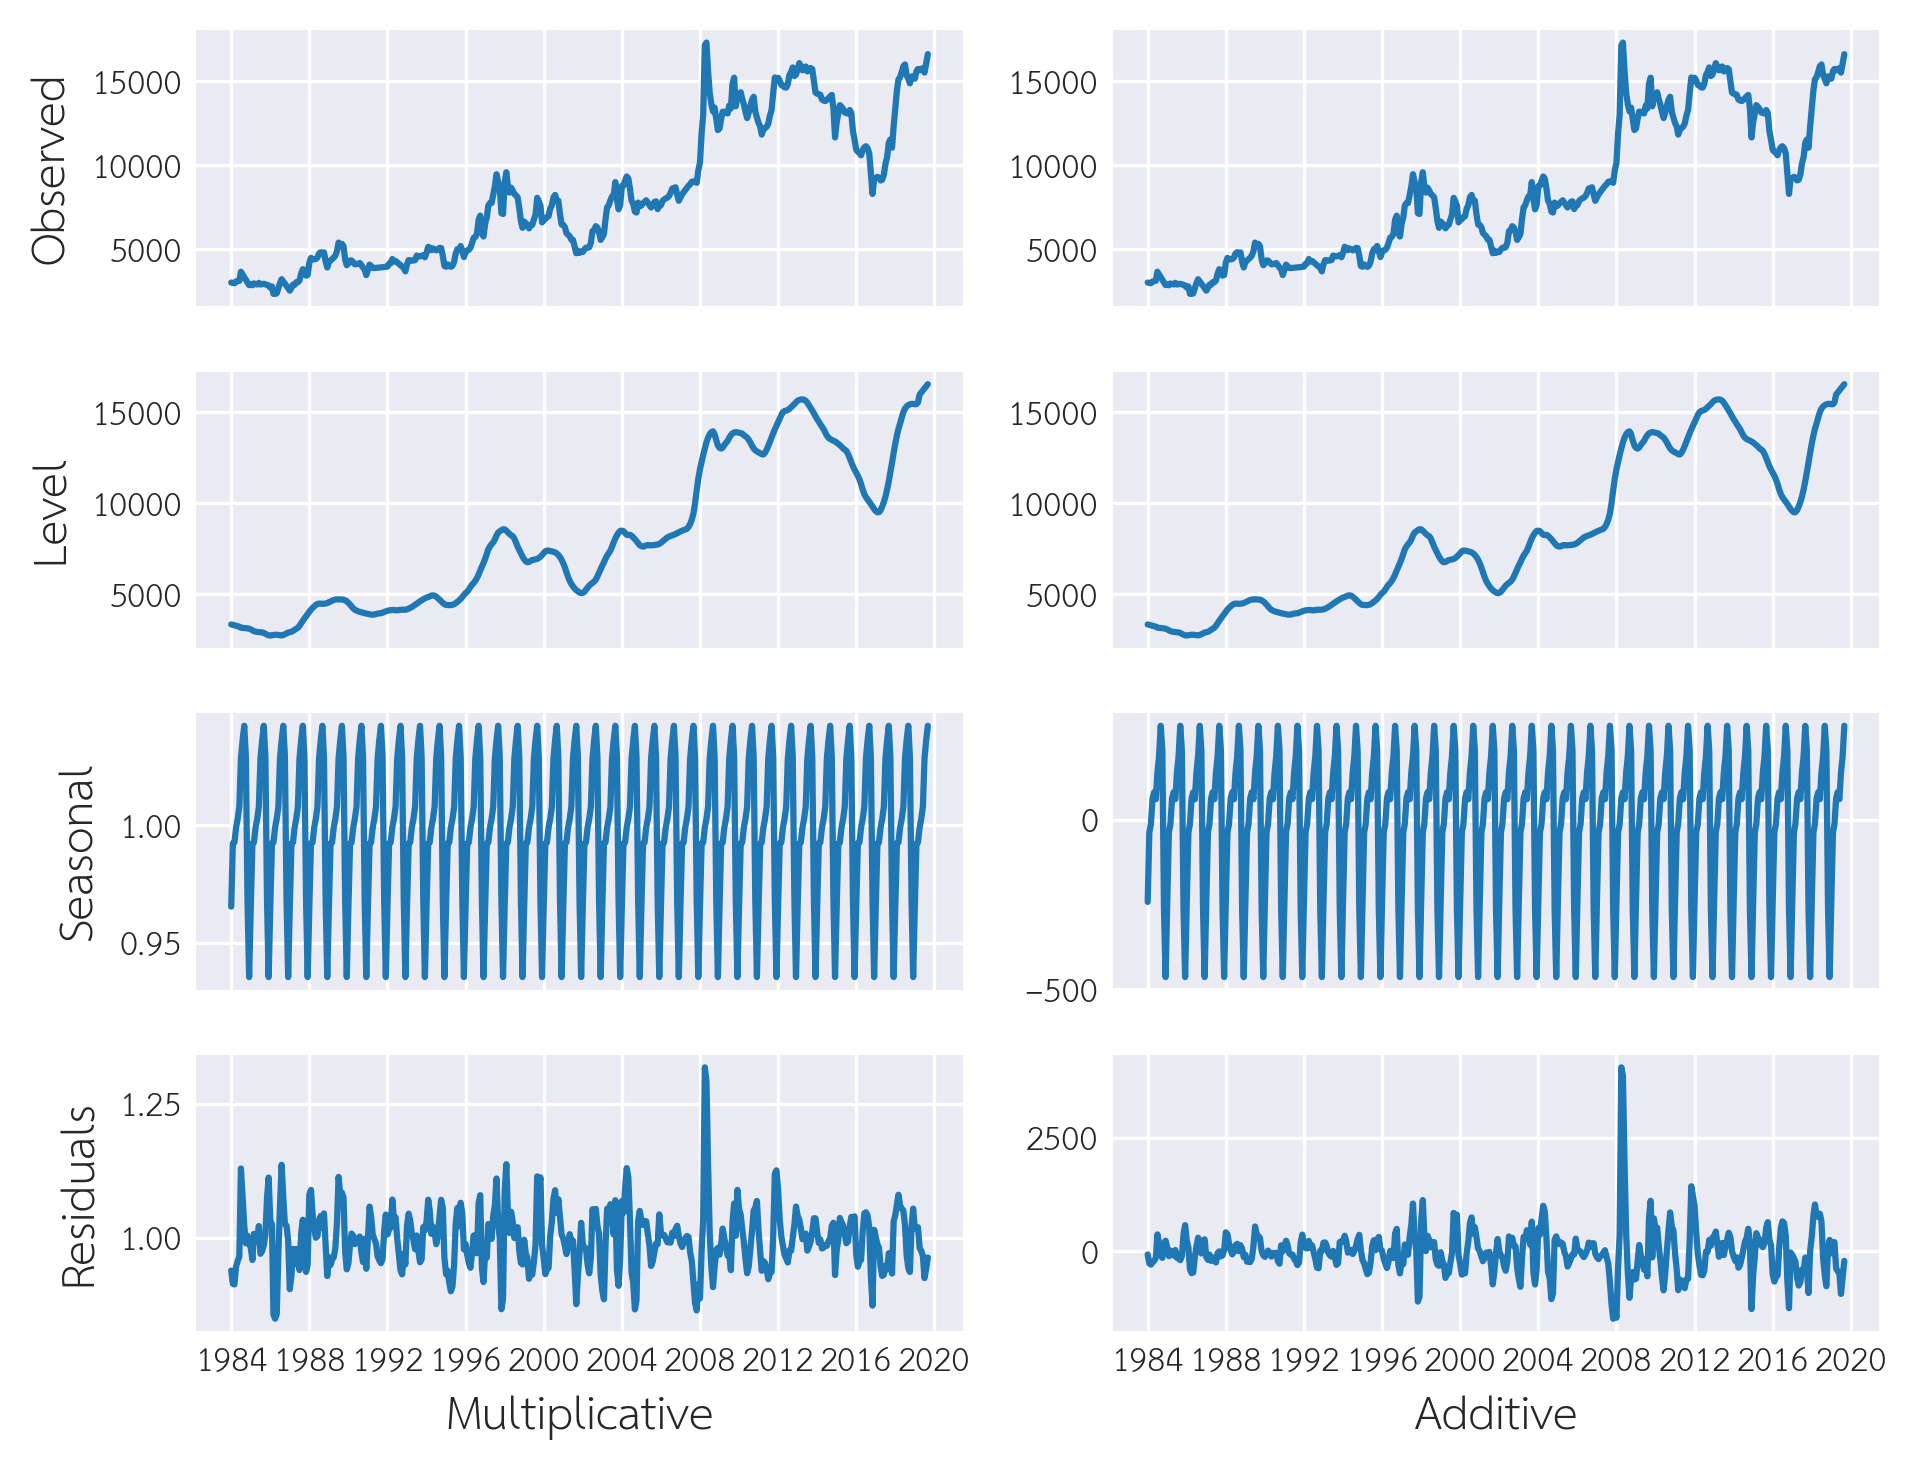

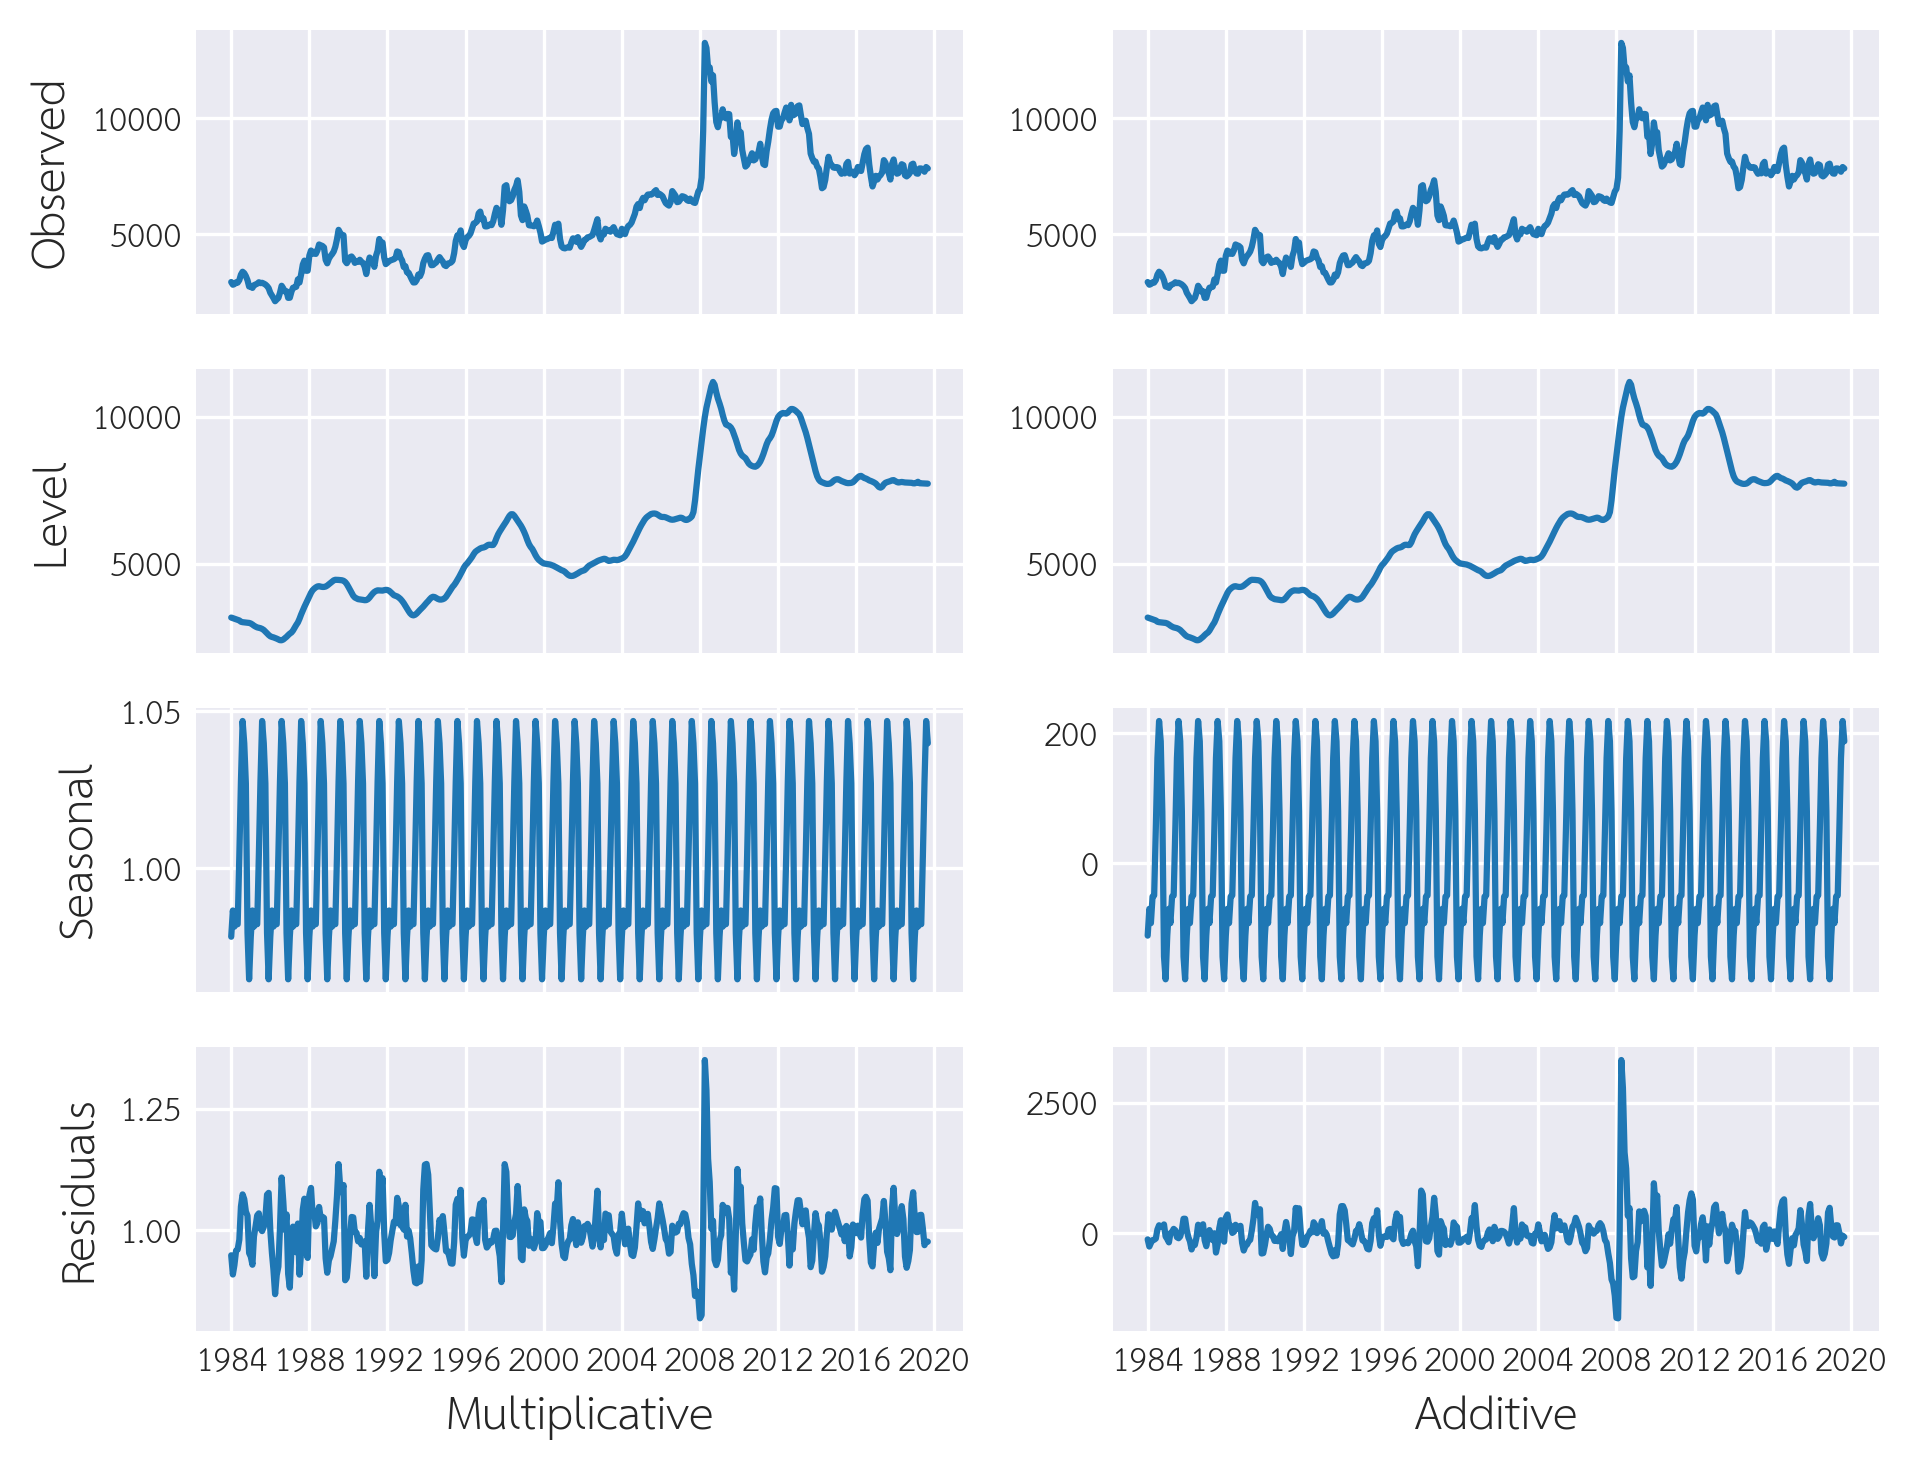

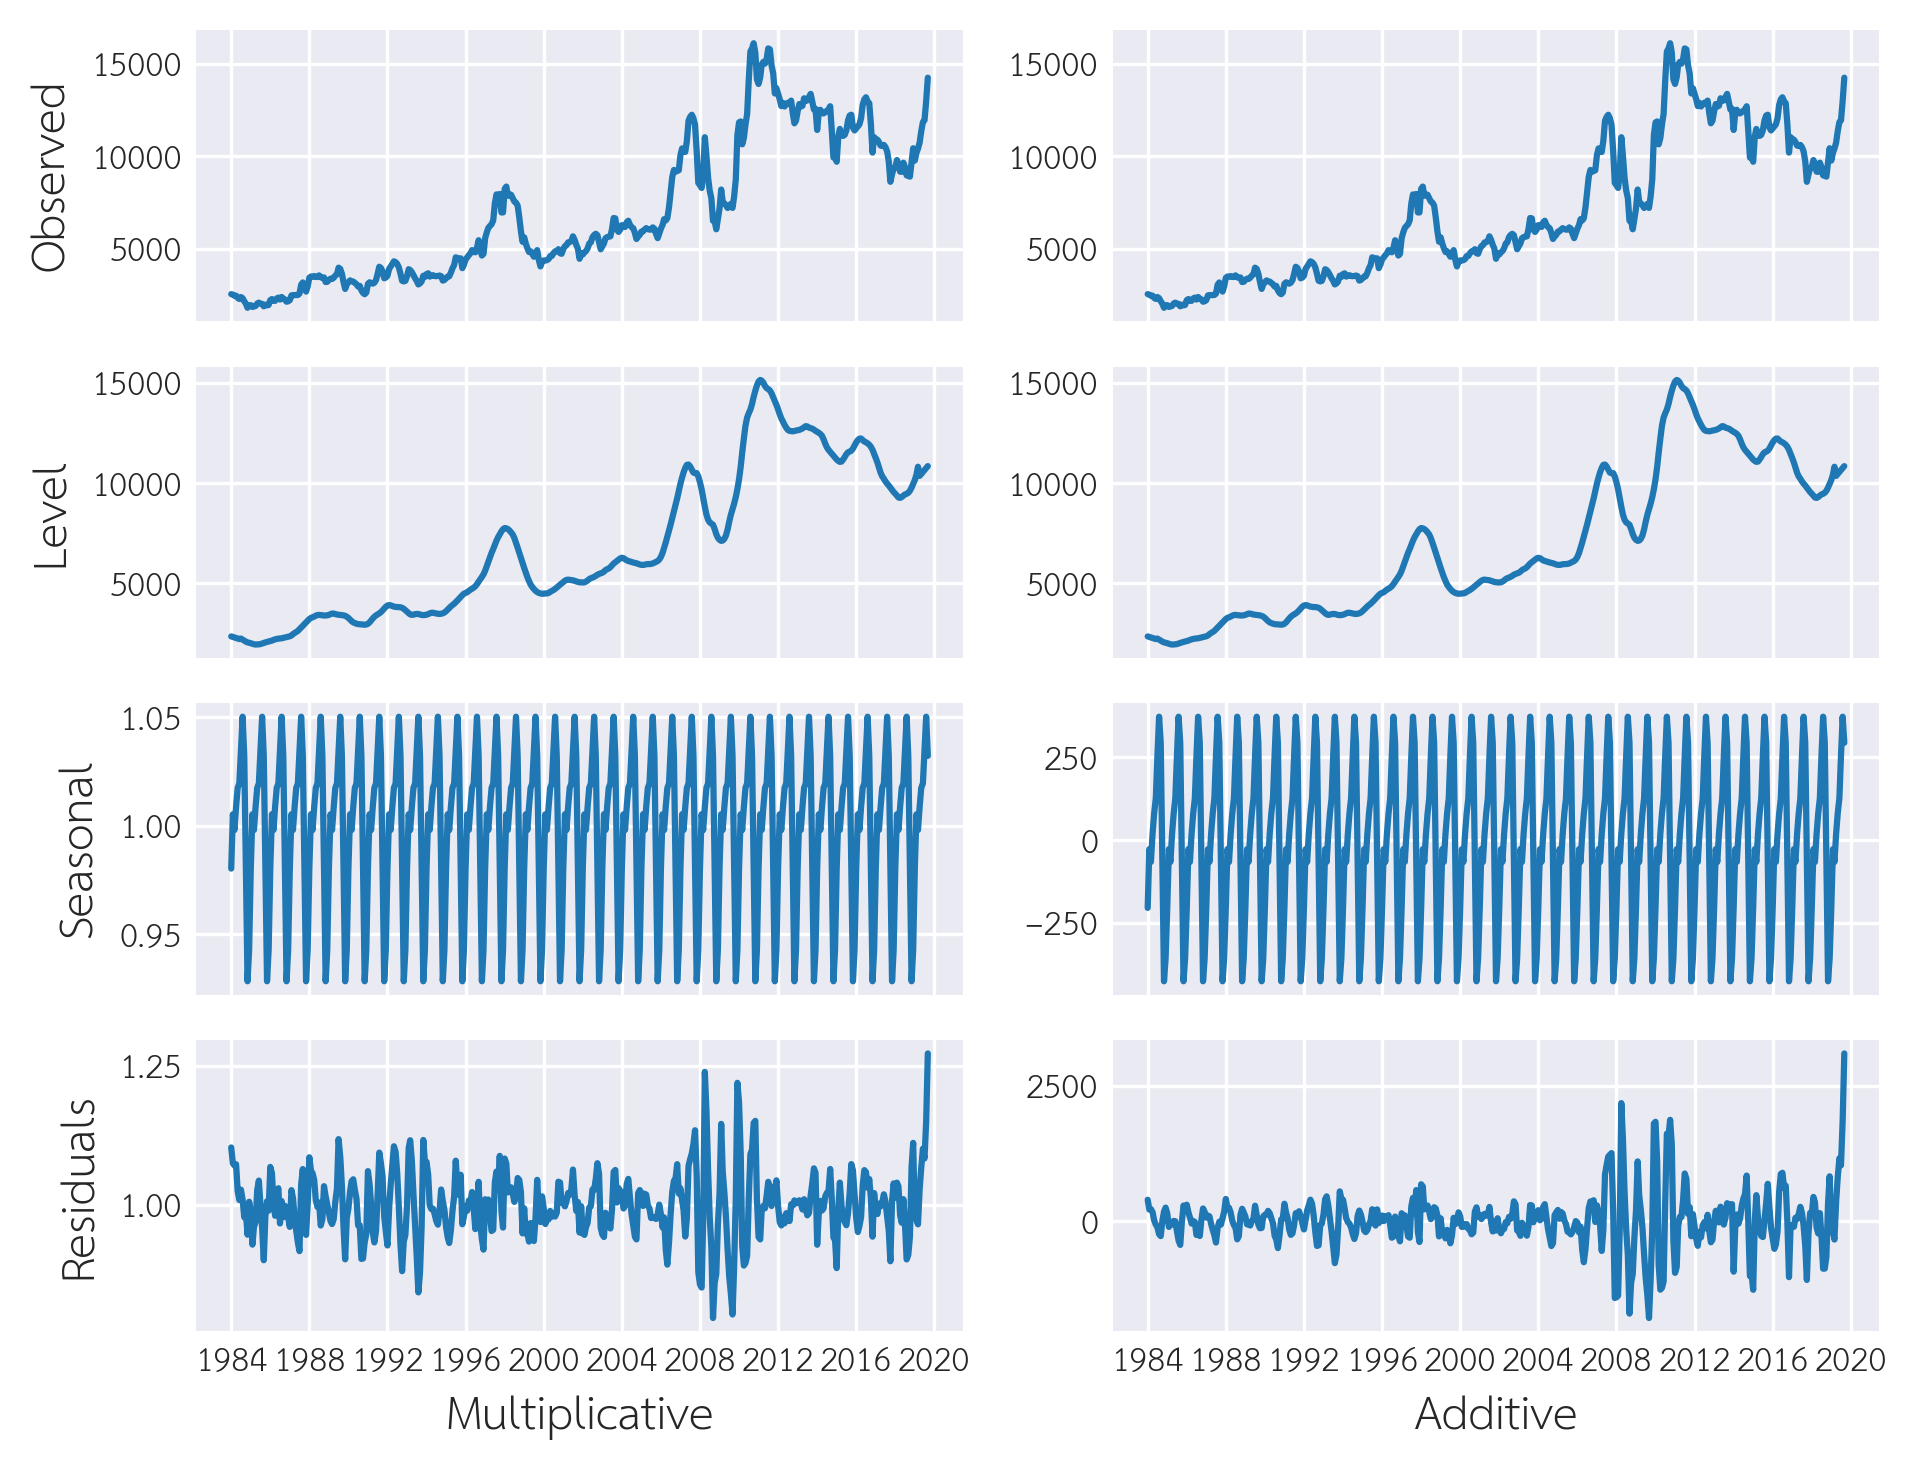

In [35]:
for price in prices:
  decom_mul = seasonal_decompose(price.y,
                                 model='mul',
                                 extrapolate_trend='freq',
                                )
  decom_add = seasonal_decompose(price.y,
                                 model='add',
                                 extrapolate_trend='freq',
                                )

  fig, axs = plt.subplots(4, 2, sharex=True, figsize=(6.5, 5))

  axs[0,0].plot(decom_mul.observed.index, decom_mul.observed)
  axs[1,0].plot(decom_mul.trend)
  axs[2,0].plot(decom_mul.seasonal)
  axs[3,0].plot(decom_mul.resid)

  axs[0,1].plot(decom_add.observed.index, decom_add.observed)
  axs[1,1].plot(decom_add.trend)
  axs[2,1].plot(decom_add.seasonal)
  axs[3,1].plot(decom_add.resid)
  for ix, i in enumerate(['Observed', 'Level', 'Seasonal', 'Residuals']):
      axs[ix, 0].set(ylabel=i)

  axs[3,0].set_xlabel('Multiplicative')
  axs[3,1].set_xlabel('Additive')
  plt.tight_layout()
#     fig.savefig(f'../figures/02_{price.meta.abb}_decomp.png', dpi=300)

## Stationary Test
ทดสอบคุณสมบัติ stataionry ด้วย 2 วิธี ได้แก่ Augmented Dickey–Fuller test และ KPSS test


In [39]:
for price in prices:
  price.scaled, price.scaler = data_transform(price, method="log")
  price.train, price.validate, price.train2, price.test = data_split(price.scaled)
  print(price.meta.abb, price.train.size, price.validate.size, price.test.size)

hml 259 85 85
wht 259 85 85
glu 259 85 85


In [42]:
hml.scaled

,y
date,
1984-01-01,8.0146
1984-02-01,8.0079
1984-03-01,7.9995
1984-04-01,8.0345
1984-05-01,8.0411
...,...
2019-05-01,9.6631
2019-06-01,9.6659
2019-07-01,9.6491


In [46]:
res_stationary = pd.DataFrame()
for price in prices:
  res_stationary = res_stationary.append(test_stationary(price.scaled, spec='c'))
res_stationary

adf_stat  adf_pval  kpss_stat  kpss_pval
price level                                          
y     level   -1.2504    0.6516     2.1524     0.0100
      diff1   -5.1732    0.0000     0.0281     0.1000
      level   -1.8841    0.3396     1.9924     0.0100
      diff1   -5.3275    0.0000     0.0553     0.1000
      level   -1.2970    0.6305     2.1392     0.0100
      diff1   -5.4724    0.0000     0.0259     0.1000

**ผลทดสอบ**  
ผลการทดสอบ Stationary ด้วยวิธี ADF และ KPSS ระบุว่าข้อมูลราคาทั้งสามชนิดเป็นข้อมูล I(1)

In [21]:
from pmdarima.arima import CHTest
chtest = CHTest(12)

In [22]:
chtest.crit_vals[10]

2.7391007

In [23]:
ch_res = pd.DataFrame(columns=["ch_stat"])
for price in prices:
    ch_res.loc[price.meta.abb] = chtest._sd_test(price.y.to_numpy(), 12)
ch_res

,ch_stat
hml,0.8488
wht,1.0760
glu,1.0341


## Data Transformation

In [28]:
for price in prices:
  price.scaled, price.scaler = data_transform(price, method=None)
  price.train, price.validate, price.train2, price.test = data_split(price.scaled)

In [29]:
hml.train

,y
date,
1984-01-01,"3,024.8013"
1984-02-01,"3,004.5982"
1984-03-01,"2,979.4107"
1984-04-01,"3,085.4853"
1984-05-01,"3,106.0813"
...,...
2005-03-01,"7,816.0000"
2005-04-01,"7,913.0000"
2005-05-01,"7,769.0000"


In [30]:
hml.validate

,y
date,
2005-08-01,"7,618.0000"
2005-09-01,"7,816.0000"
2005-10-01,"7,850.0000"
2005-11-01,"7,393.0000"
2005-12-01,"7,579.0000"
...,...
2012-04-01,"14,752.0000"
2012-05-01,"14,628.0000"
2012-06-01,"14,616.0000"
